# Image Segmentation Demo
Jack Eiel  
Final Project  
CSCI-E89 Deep Learning  
May 13, 2020  

![title](notebook_pics/img_seg2.png)

_______

![title](notebook_pics/one_hot.png)

_______

![title](notebook_pics/model.png)

In [1]:
import os

import tensorflow as tf
from tensorflow.keras.models import load_model

import numpy as np

import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')

This short notebook demonstrates the abilities of the model built in the notebook titled Image Segmentation. 

These utils have been pulled from the notebook titled Image Segmentation.

In [2]:
# utils
# processing utils
def process_img(img):
    img = tf.io.read_file(img)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, (128, 128)) 
    
    return img
    
def process_mask(mask):
    mask = tf.io.read_file(mask)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.image.resize(mask, (128, 128), method='nearest')
    mask = tf.image.rgb_to_grayscale(mask)
    
    return mask

class2pix = {0: 0,
             1: 14,
             2: 19,
             3: 33,
             4: 37,
             5: 38,
             6: 52,
             7: 57,
             8: 72,
             9: 75,
             10: 89,
             11: 94,
             12: 109,
             13: 112,
             14: 113,
             15: 128,
             16: 132,
             17: 147,
             18: 151,
             19: 220}

pix2class = {0: 0,
             14: 1,
             19: 2,
             33: 3,
             37: 4,
             38: 5,
             52: 6,
             57: 7,
             72: 8,
             75: 9,
             89: 10,
             94: 11,
             109: 12,
             112: 13,
             113: 14,
             128: 15,
             132: 16,
             147: 17,
             151: 18,
             220: 19}

####################################################

# vectorizing this function makes it run much faster
def f(x):
    '''
    converts pixels to classes
    '''
    return pix2class[x]
pix2class_f = np.vectorize(f)

####################################################

# viz. utils
def f2(x):
    '''
    convert classes to pixels
    '''
    return class2pix[x]
class2pix_f = np.vectorize(f2)

##############################

def create_mask(predictions):
    '''
    param: sparse mask(s), shape=?, 128, 128, 20
    
    returns: pixel wise mask(s), shape==?, 128, 128
        pixels: 0 -> 255
    '''
    mask = tf.argmax(predictions, axis=-1) # -> ? 128, 128
    mask = class2pix_f(mask.numpy())
    return mask

##############################

def show_example(img_list):
    '''
    original.shape == 128, 128, 3
    mask.shape == 128, 128, 20
    pred.shape == 128, 128, 20
    '''
    titles = ['Original', 'Mask', 'Predicted']
    
    fig, ax = plt.subplots(1, len(img_list), figsize=(10,10))
    
    ax[0].set_title(titles[0])
    ax[0].imshow(img_list[0])
    ax[0].axis('off')
    
    mask = create_mask(img_list[1])
    ax[1].imshow(mask, vmin=0, vmax=255)
    ax[1].set_title(f'Mask')
    ax[1].axis('off')
    
    if len(img_list)==3:
        i = 2
        pred = create_mask(img_list[2])
        ax[i].imshow(pred, vmin=0, vmax=255)
        ax[i].set_title(f'Predicted')
        ax[i].axis('off')
        

First we will read in the image and mask files.

In [12]:
new_dir = os.path.join('example_pics', 'new')
new_names = os.listdir(new_dir)
new =[process_img(os.path.join(new_dir, img)) for img in new_names if not img.startswith('.')]
new_img = tf.stack(new)

In [4]:
mask_dir = os.path.join('example_pics', 'masks')
img_dir = os.path.join('example_pics', 'images')

In [5]:
png = '.png'
jpeg = '.jpg'

fnames = os.listdir(mask_dir)
# generate lists of file names
mask_fnames = [os.path.join(mask_dir, i) for i in fnames]
img_fnames = [os.path.join(img_dir, i.replace(png, jpeg)) for i in fnames]

masks = [process_mask(mask) for mask in mask_fnames]
images = [process_img(img) for img in img_fnames]

x = tf.stack(images)
y = tf.stack(masks)[:, :, :, 0]
y = pix2class_f(y)
y = tf.keras.utils.to_categorical(y)

Next, we load the model. 

In [6]:
# need the custom objects to load 
def weighted_loss(y_true, y_pred):
    return tf.nn.weighted_cross_entropy_with_logits(y_true, y_pred, pos_weight=1.2, name='weighted_loss')

class MIOU(): 
    def __init__(self):
        self.__name__ = 'dice'
        self.loss = miou = tf.keras.metrics.MeanIoU(num_classes=20, name='miou')


    def __call__(self, y_true, y_pred, sample_weight=None):
        y_pred_cat = tf.keras.activations.softmax(y_pred, axis=-1)
        
        return self.loss(y_true, y_pred_cat)

model_path = os.path.join('..', 'models' ,'unet4.h5')
model = load_model(model_path, custom_objects={'weighted_loss': weighted_loss, 'dice': MIOU}, compile=False)

These are the original images as well as their masks. 

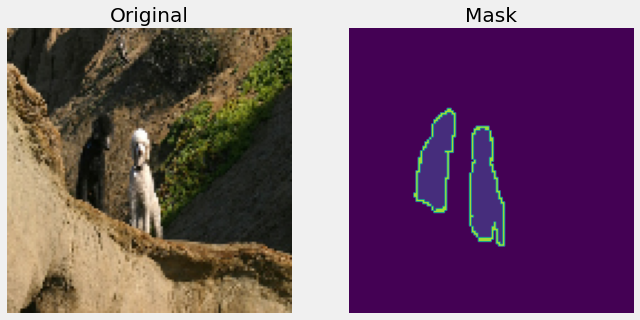

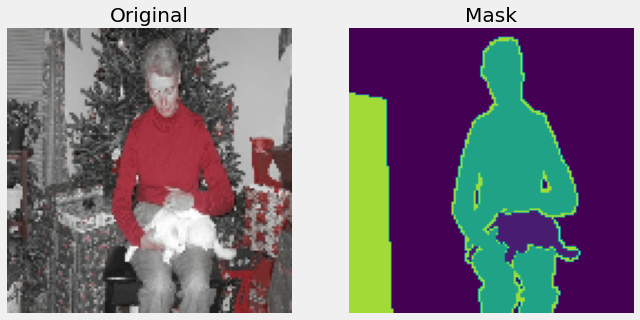

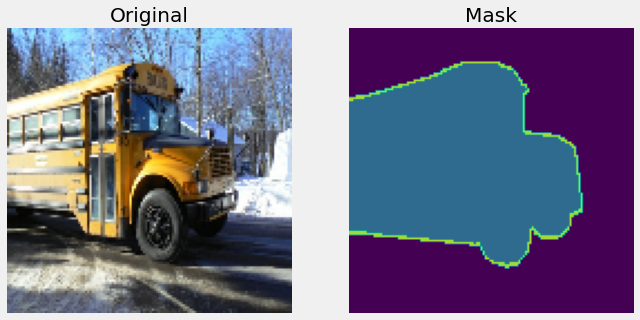

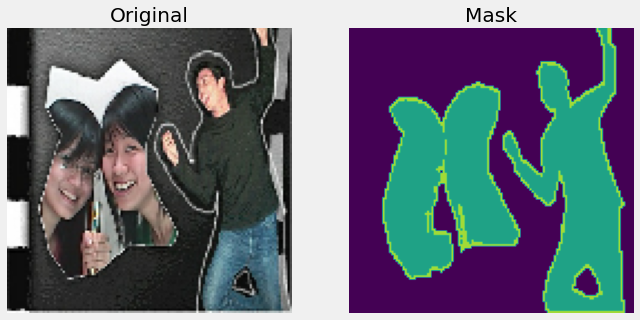

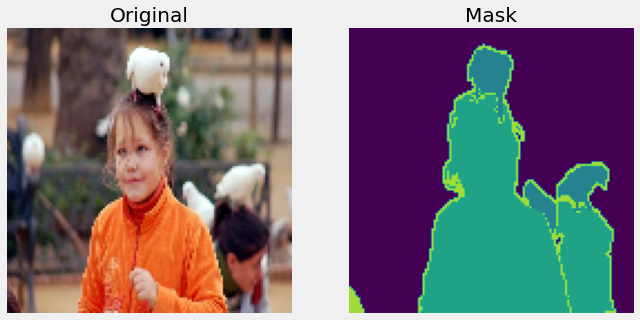

In [7]:
for i in range(5):
    show_example([x[i], y[i]])

Now, let's use the model to predict masks for these images.

In [8]:
preds = model.predict(x)

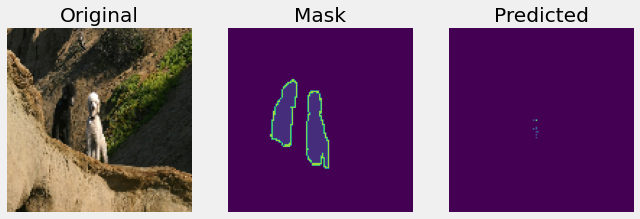

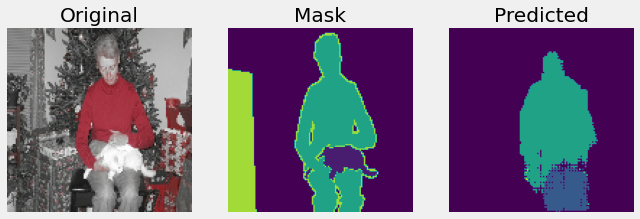

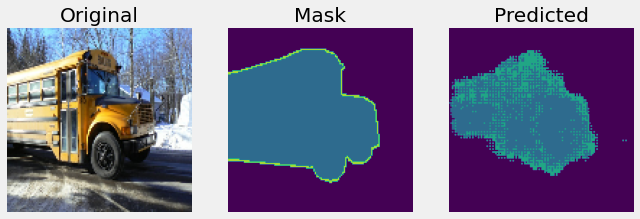

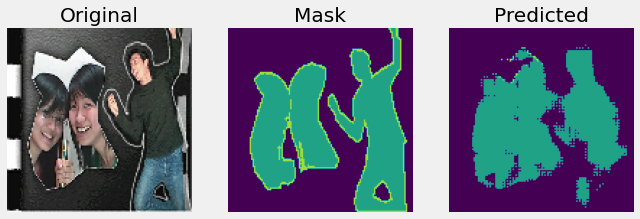

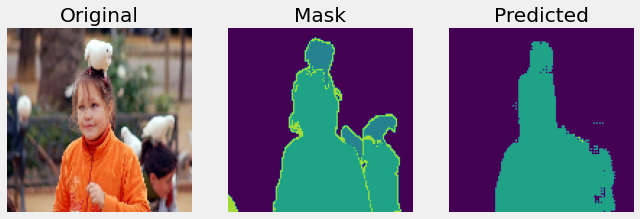

In [9]:
for i in range(5):
    show_example([x[i], y[i], preds[i]])

Now, just for fun, let's see how our model masks these pictures of mine. 

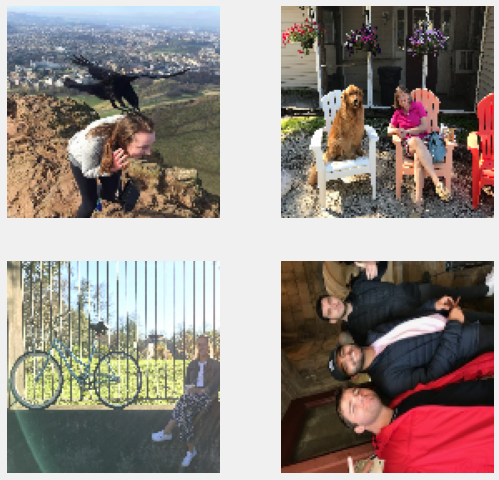

In [13]:
fig, ax = plt.subplots(2,2, figsize=(8,8))
ax = ax.ravel()

for i in range(len(new_img)):
    ax[i].imshow(new_img[i])
    ax[i].axis('off')

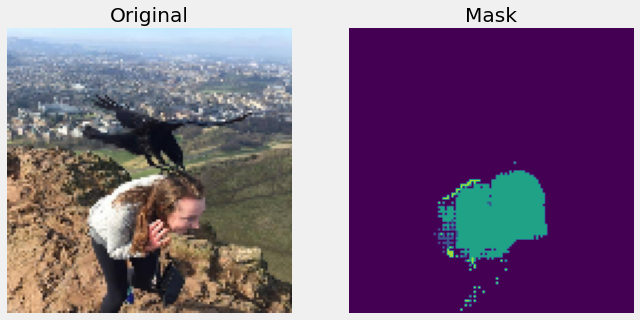

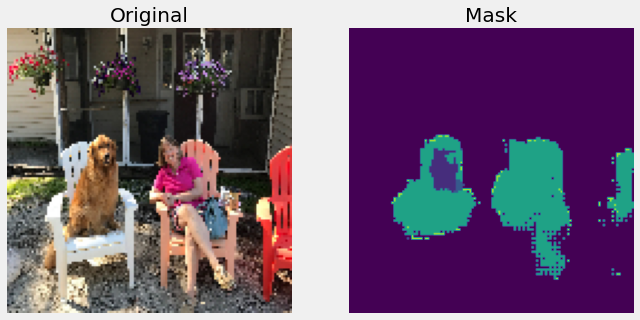

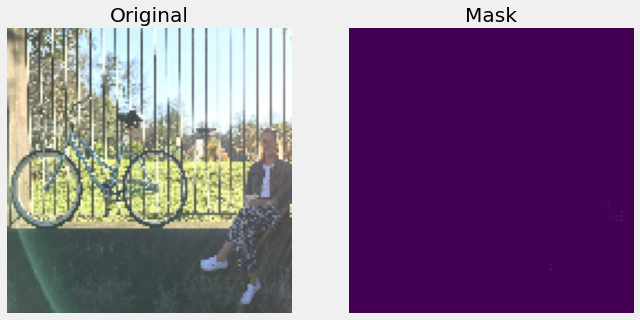

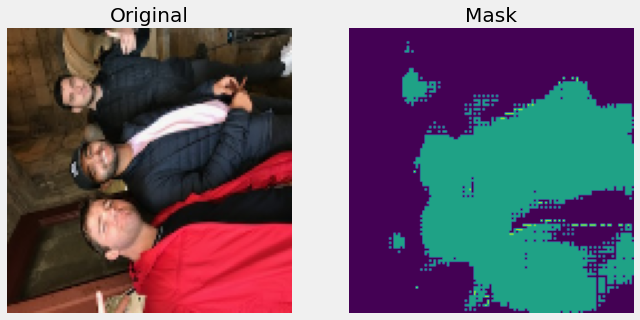

In [14]:
new_preds = model.predict(new_img)

for i in range(len(new_preds)):
    show_example([new_img[i], new_preds[i]])